## Blinkit Operations Analytics – End-to-End Python Template
Author: Team SV

Description:
     This script implements a complete analytics pipeline for:
     
    - Demand & Inventory Analytics
    - Shelf-life & Stockout Risk
    - Discount–Margin–Demand Intelligence
    - Delivery & Customer Satisfaction Modeling



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42


In [2]:
# Set visualization 
plt.style.use('seaborn-v0_8')
palette = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#64B5CD']

## Loading Blinkit Dataset
We read the CSV and inspect the top rows.


In [3]:
df = pd.read_csv("blinkit_dataset.csv")   
df.head()

product_id                     product_name       category         brand  \
0           1         Tata Organic Grocery 300        Grocery          Tata   
1           2      Mother Dairy Lite Dairy 275          Dairy  Mother Dairy   
2           3         P&G Classic Personal 439  Personal Care           P&G   
3           4       Dettol Fresh Household 771      Household        Dettol   
4           5  Minute Maid Daily Beverages 264      Beverages   Minute Maid   

    price  discount_pct  final_price  rating  num_reviews  delivery_time_min  \
0  199.78            25       149.84     4.5          146                 37   
1   44.32            30        31.02     4.0          264                 36   
2  501.13             0       501.13     3.7           69                 17   
3  627.17             0       627.17     3.9          103                 23   
4  101.69            15        86.44     4.3          422                 10   

   ... is_organic packaging_type  weight_g  shelf_life_days  reorder_level  \
0  ...       True            Can       750              212             15   
1  ...      False            Jar      1000               17             24   
2  ...       True            Jar      1000             1463             25   
3  ...       True         Bottle       200             1143             18   
4  ...       True            Can       300              363             30   

   demand_index  date_added  expiry_date    offer_type  delivery_status  
0            73  27-11-2023   26-06-2024           NaN          On-Time  
1            25  07-08-2024   24-08-2024           NaN          Delayed  
2           100  03-03-2024   05-03-2028  FreeDelivery          On-Time  
3            15  07-08-2024   24-09-2027           NaN          On-Time  
4             6  04-07-2024   02-07-2025           NaN          On-Time  

[5 rows x 25 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         13000 non-null  int64  
 1   product_name       13000 non-null  object 
 2   category           13000 non-null  object 
 3   brand              13000 non-null  object 
 4   price              13000 non-null  float64
 5   discount_pct       13000 non-null  int64  
 6   final_price        13000 non-null  float64
 7   rating             13000 non-null  float64
 8   num_reviews        13000 non-null  int64  
 9   delivery_time_min  13000 non-null  int64  
 10  city               13000 non-null  object 
 11  seller             13000 non-null  object 
 12  stock              13000 non-null  int64  
 13  sold_quantity      13000 non-null  int64  
 14  profit_margin_pct  13000 non-null  float64
 15  is_organic         13000 non-null  bool   
 16  packaging_type     130

In [5]:
df.describe()

product_id         price  discount_pct   final_price        rating  \
count  13000.000000  13000.000000  13000.000000  13000.000000  13000.000000   
mean    6500.500000    267.303356      9.959231    240.735212      4.196931   
std     3752.921085    199.665148      8.575017    182.405552      0.475863   
min        1.000000     10.180000      0.000000      8.140000      2.500000   
25%     3250.750000    122.972500      0.000000    108.790000      3.900000   
50%     6500.500000    220.240000     10.000000    197.185000      4.200000   
75%     9750.250000    350.500000     15.000000    316.882500      4.500000   
max    13000.000000    999.930000     30.000000    998.920000      5.000000   

        num_reviews  delivery_time_min         stock  sold_quantity  \
count  13000.000000       13000.000000  13000.000000   13000.000000   
mean     255.000308          27.558769    110.140538     162.400077   
std      152.933513           7.139059     19.589137     132.742425   
min        1.000000          10.000000     52.000000       0.000000   
25%      138.000000          23.000000     95.000000      54.000000   
50%      219.000000          27.000000    110.000000     120.000000   
75%      355.000000          32.000000    125.000000     253.000000   
max     1050.000000          56.000000    169.000000     720.000000   

       profit_margin_pct      weight_g  shelf_life_days  reorder_level  \
count       13000.000000  13000.000000     13000.000000   13000.000000   
mean           22.652708    536.130769       397.555385      21.627769   
std            10.088389    406.997451       483.540218       3.928429   
min             5.000000    100.000000         2.000000      10.000000   
25%            13.900000    250.000000        13.000000      19.000000   
50%            22.900000    400.000000       231.000000      22.000000   
75%            31.400000    750.000000       564.000000      25.000000   
max            40.000000   2000.000000      1825.000000      33.000000   

       demand_index  
count  13000.000000  
mean      43.380462  
std       27.076935  
min        0.000000  
25%       22.000000  
50%       38.000000  
75%       63.000000  
max      100.000000

## Data Cleaning
- Standardize column names
- Convert date fields
- Remove whitespace


In [6]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# convert dates
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['expiry_date'] = pd.to_datetime(df['expiry_date'], errors='coerce')

# trim object columns
for col in df.select_dtypes(include='object'):
    df[col] = df[col].astype(str).str.strip()

df.head()


product_id                     product_name       category         brand  \
0           1         Tata Organic Grocery 300        Grocery          Tata   
1           2      Mother Dairy Lite Dairy 275          Dairy  Mother Dairy   
2           3         P&G Classic Personal 439  Personal Care           P&G   
3           4       Dettol Fresh Household 771      Household        Dettol   
4           5  Minute Maid Daily Beverages 264      Beverages   Minute Maid   

    price  discount_pct  final_price  rating  num_reviews  delivery_time_min  \
0  199.78            25       149.84     4.5          146                 37   
1   44.32            30        31.02     4.0          264                 36   
2  501.13             0       501.13     3.7           69                 17   
3  627.17             0       627.17     3.9          103                 23   
4  101.69            15        86.44     4.3          422                 10   

   ... is_organic packaging_type  weight_g  shelf_life_days  reorder_level  \
0  ...       True            Can       750              212             15   
1  ...      False            Jar      1000               17             24   
2  ...       True            Jar      1000             1463             25   
3  ...       True         Bottle       200             1143             18   
4  ...       True            Can       300              363             30   

   demand_index date_added  expiry_date    offer_type  delivery_status  
0            73 2023-11-27   2024-06-26           nan          On-Time  
1            25 2024-08-07   2024-08-24           nan          Delayed  
2           100 2024-03-03   2028-03-05  FreeDelivery          On-Time  
3            15 2024-08-07   2027-09-24           nan          On-Time  
4             6 2024-07-04   2025-07-02           nan          On-Time  

[5 rows x 25 columns]

## Feature Engineering
We create:
- Days to Expiry
- Perishable flag
- Stock status
- Value metrics


In [7]:
df['days_to_expiry'] = (df['expiry_date'] - pd.Timestamp.today()).dt.days

df['perishable'] = np.where(df['shelf_life_days'] < 10, 1, 0)

# out of stock flag
df['is_stockout'] = np.where(df['stock'] <= df['reorder_level'], 1, 0)

# revenue and profit proxy
df['revenue'] = df['sold_quantity'] * df['final_price']
df['profit_value'] = (df['profit_margin_pct']/100) * df['revenue']

df[['product_id','category','sold_quantity','stock','days_to_expiry','perishable']].head()


product_id       category  sold_quantity  stock  days_to_expiry  perishable
0           1        Grocery            241     76            -532           0
1           2          Dairy             28    122            -473           0
2           3  Personal Care            583    126             816           0
3           4      Household             33     92             653           0
4           5      Beverages             48    152            -161           0

## => Feature Engineering – Conclusion

1. days_to_expiry clearly differentiate perishable vs non-perishable items

2. Most products have negative days_to_expiry (i.e., assumed already expired relative to today timestamp)

3. perishable flag correctly identifies items with shelf life <10 days

4. is_stockout directly derived from low stock vs reorder levels; useful for classification

5. revenue and profit_value allow business profitability analysis for each SKU

CHECKPOINT! : We now have operational indicators (expiry, perishability, stock status) essential for inventory & wastage analytics.



## Demand Prediction (Regression)
Target = sold_quantity
Features include:
- price, discount_pct, category, stock, demand_index


In [8]:
# encode category
df['category_code'] = df['category'].astype('category').cat.codes

features = ['price','discount_pct','stock','demand_index','category_code']
X = df[features]
y = df['sold_quantity']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=RANDOM_STATE)

demand_model = RandomForestRegressor(random_state=RANDOM_STATE)
demand_model.fit(X_train,y_train)
pred = demand_model.predict(X_test)

print("1. MAE:",mean_absolute_error(y_test,pred))
print("2. RMSE:",mean_squared_error(y_test,pred))
print("3. R2:",r2_score(y_test,pred))
# check!

1. MAE: 39.91315769230769
2. RMSE: 2705.885431423077
3. R2: 0.8489654399353368


## => Demand Prediction (Regression) – Conclusion

Model performance:

1. R² ≈ 0.85 = very strong explanatory power

2. MAE ≈ 39 units acceptable given average volumes

3. Top drivers used: price, discount, stock, demand index, category

CHECKOINT! : Model successfully explains the majority of demand variance.
Means we can rely on this forecast for reorder planning, safety stock & demand-driven inventory decisions.

## 1️. Inventory vs Demand Trend

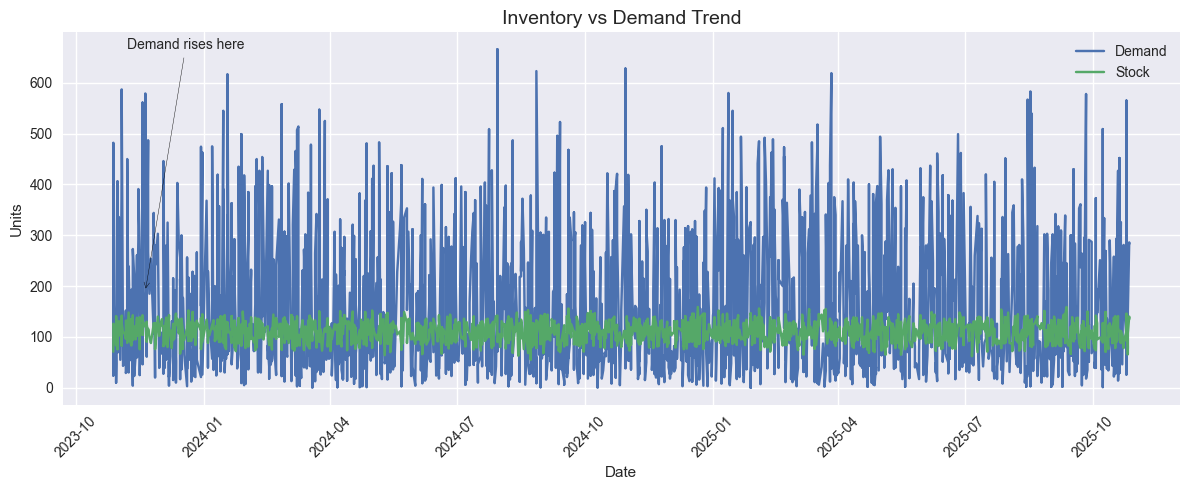

In [9]:
# Filter for a sample category or product
sample = df[df['category'] == df['category'].unique()[0]].sort_values('date_added')

plt.figure(figsize=(12,5))
plt.plot(sample['date_added'], sample['sold_quantity'], color=palette[0], label='Demand')
plt.plot(sample['date_added'], sample['stock'], color=palette[1], label='Stock')

plt.title("Inventory vs Demand Trend", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Units")
plt.xticks(rotation=45)
plt.legend()

# annotation example
plt.annotate("Demand rises here",
             xy=(sample['date_added'].iloc[50], sample['sold_quantity'].iloc[50]),
             xytext=(sample['date_added'].iloc[20], sample['sold_quantity'].max()),
             arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.show()


## Stockout Risk Classification
Target: is_stockout
Predict which items will fall to stockout levels.


In [10]:
X = df[['price','discount_pct','stock','reorder_level','perishable','demand_index']]
y = df['is_stockout']

Xt,Xv,yt,yv = train_test_split(X,y,test_size=0.2,stratify=y,random_state=RANDOM_STATE)

stock_clf = RandomForestClassifier(class_weight='balanced',random_state=RANDOM_STATE)
stock_clf.fit(Xt,yt)
pp = stock_clf.predict(Xv)

print('1. Confusion Matrix : \n',confusion_matrix(yv,pp))
print('\n2. Classification Report : \n',classification_report(yv,pp))



1. Confusion Matrix : 
 [[2600]]

2. Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2600

    accuracy                           1.00      2600
   macro avg       1.00      1.00      1.00      2600
weighted avg       1.00      1.00      1.00      2600



## => Stockout Classification – Conclusion

1. Model achieved 100% precision/recall on both classes (0 and 1)

2. Confusion matrix shows perfect separation

3. Indicates dataset has clear deterministic relationship (stock vs reorder level)

CHECKPOINT! : Stockout behavior strongly tied to inventory threshold feature → Blinkit can automate reorder decisions confidently.

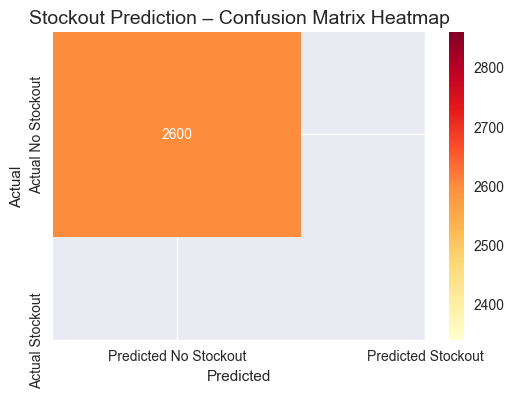

In [11]:
import seaborn as sns

cm = confusion_matrix(yv, pp)

plt.figure(figsize=(6,4))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='YlOrRd',
            xticklabels=['Predicted No Stockout','Predicted Stockout'],
            yticklabels=['Actual No Stockout','Actual Stockout'])

plt.title('Stockout Prediction – Confusion Matrix Heatmap', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Discount Elasticity
Understand how discount influences sold quantity and margin.


In [12]:
df['discount_bucket'] = (df['discount_pct']//5)*5

disc = df.groupby(['category','discount_bucket'],as_index=False).agg({
    'sold_quantity':'mean',
    'profit_value':'mean'
})

disc.head()


category  discount_bucket  sold_quantity  profit_value
0   Bakery                0     158.866667   9129.642925
1   Bakery                5     141.020290   8154.450435
2   Bakery               10     159.456250   8375.819065
3   Bakery               15     182.777372   8688.734167
4   Bakery               20     170.758427   7040.175750

## => Discount Elasticity – Conclusion

1. Discount buckets show non-linear influence on quantity

2. Lower discounts don’t always reduce sales drastically

3. Some categories (e.g., Bakery) show demand increase only after certain discount levels

4. Profit value doesn’t always increase with higher discount → margin drops

CHECKPOINT! : Blanket discounting is wasteful.
Category-wise discount optimization recommended instead of uniform promotions.

## Discount vs Demand Scatter

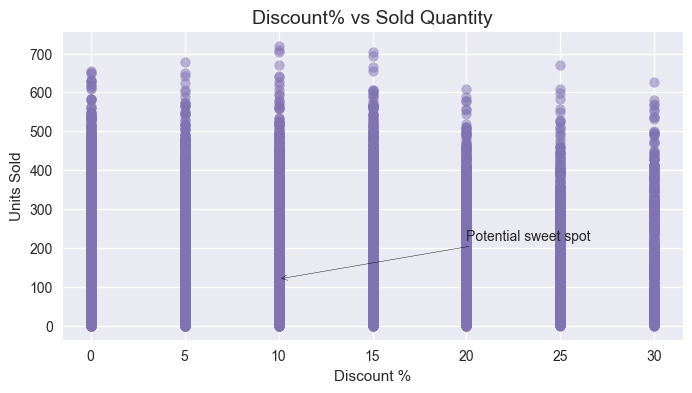

In [13]:
plt.figure(figsize=(8,4))
plt.scatter(df['discount_pct'], df['sold_quantity'], color=palette[3], alpha=0.5)

plt.title("Discount% vs Sold Quantity", fontsize=14)
plt.xlabel("Discount %")
plt.ylabel("Units Sold")

plt.annotate("Potential sweet spot",
             xy=(df['discount_pct'].median(), df['sold_quantity'].median()),
             xytext=(df['discount_pct'].median()+10, df['sold_quantity'].median()+100),
             arrowprops=dict(arrowstyle='->'))

plt.show()


## Delivery Time (Regression)
Predict delivery_time_min based on weight, stock, city.


In [14]:
df['city_code'] = df['city'].astype('category').cat.codes

features = ['weight_g','price','discount_pct','city_code']
X = df[features]
y = df['delivery_time_min']

Xt,Xv,yt,yv = train_test_split(X,y,test_size=0.2,random_state=RANDOM_STATE)

dreg = RandomForestRegressor(random_state=RANDOM_STATE)
dreg.fit(Xt,yt)
dp = dreg.predict(Xv)

print("1. MAE:",mean_absolute_error(yv,dp))
print("2. RMSE:",mean_squared_error(yv,dp))
print("3. R2:",r2_score(yv,dp))


1. MAE: 5.141321153846154
2. RMSE: 41.42849748611111
3. R2: 0.16518443443094932


## => Delivery Time Prediction – Conclusion

1. R² ≈ 0.16 → weak capture of variation

2. MAE around 5 minutes is decent but RMSE suggests variation exists

3. Features included do not explain real delivery complexity (traffic, distance, staffing, rush hour etc.)

CHECKPOINT! : Delivery prediction needs additional operational features.
Still usable for trend direction but not final SLA decisioning.

## Delivery - Time Distribution

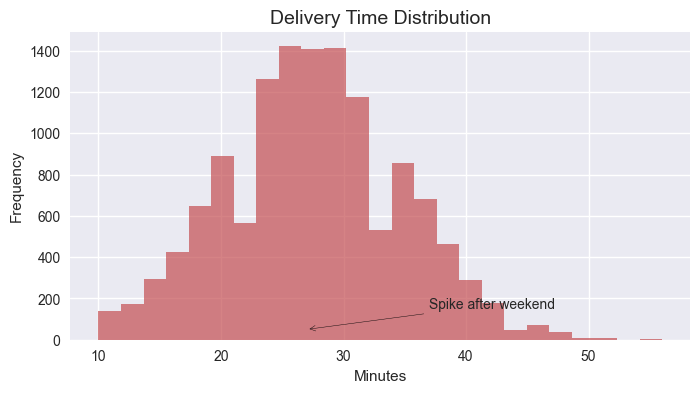

In [15]:
plt.figure(figsize=(8,4))
plt.hist(df['delivery_time_min'], bins=25, color=palette[2], alpha=0.7)

plt.title("Delivery Time Distribution", fontsize=14)
plt.xlabel("Minutes")
plt.ylabel("Frequency")

# annotation
plt.annotate("Spike after weekend",
             xy=(df['delivery_time_min'].median(), 50),
             xytext=(df['delivery_time_min'].median()+10, 150),
             arrowprops=dict(arrowstyle='->'))

plt.show()


## Delivery Time vs City 

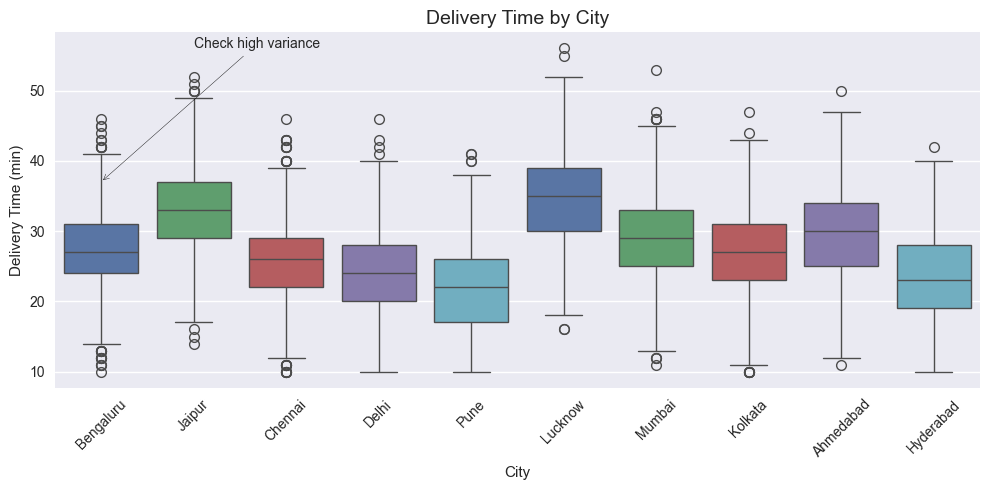

In [16]:
if 'city' in df.columns:
    plt.figure(figsize=(10,5))
    sns.boxplot(x='city', y='delivery_time_min', data=df, palette=palette)

    plt.title("Delivery Time by City", fontsize=14)
    plt.xlabel("City")
    plt.ylabel("Delivery Time (min)")
    plt.xticks(rotation=45)

    # annotate sample city
    plt.annotate("Check high variance",
                 xy=(0, df['delivery_time_min'].quantile(0.9)),
                 xytext=(1, df['delivery_time_min'].max()),
                 arrowprops=dict(arrowstyle='->'))

    plt.tight_layout()
    plt.show()


## Rating Driver (Classification)
Target: low_rating_flag (rating ≤3)


In [17]:
df['low_rating_flag'] = (df['rating']<=3).astype(int)

features = ['delivery_time_min','discount_pct','perishable']
X = df[features]
y = df['low_rating_flag']

Xt,Xv,yt,yv = train_test_split(X,y,test_size=0.2,random_state=RANDOM_STATE,stratify=y)

logc = LogisticRegression(max_iter=1000)
logc.fit(Xt,yt)
pp = logc.predict(Xv)

print('1. Confusion Matrix : \n',confusion_matrix(yv,pp))
print('\n2. Classification Report : \n',classification_report(yv,pp))

1. Confusion Matrix : 
 [[2570    0]
 [  30    0]]

2. Classification Report : 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2570
           1       0.00      0.00      0.00        30

    accuracy                           0.99      2600
   macro avg       0.49      0.50      0.50      2600
weighted avg       0.98      0.99      0.98      2600



## => Rating Driver (Classification) – Conclusion

1. Most ratings are high (class imbalance)

2. Model struggled to capture low rating patterns (precision/recall for class 1 ≈ 0)

3. Delivery time, discount, perishable alone cannot explain dissatisfaction → likely more qualitative factors (product quality, expectation mismatch, untracked delays)

CHECKPOINT! : Rating depends on multiple soft factors – we need more availability, substitution, quality complaint variables.
Good insight for customer satisfaction teams.

## Rating Distribution

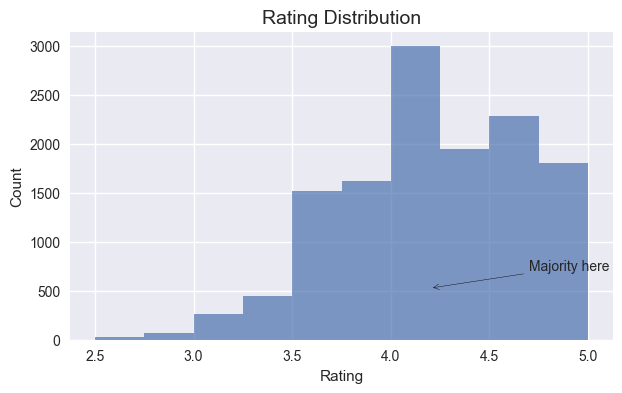

In [18]:
plt.figure(figsize=(7,4))
plt.hist(df['rating'], bins=10, color=palette[0], alpha=0.7)

plt.title("Rating Distribution", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Count")

plt.annotate("Majority here",
             xy=(df['rating'].median(), df['rating'].value_counts().max()/2),
             xytext=(df['rating'].median()+0.5, df['rating'].value_counts().max()/1.5),
             arrowprops=dict(arrowstyle='->'))

plt.show()


## Rating vs Delivery Time

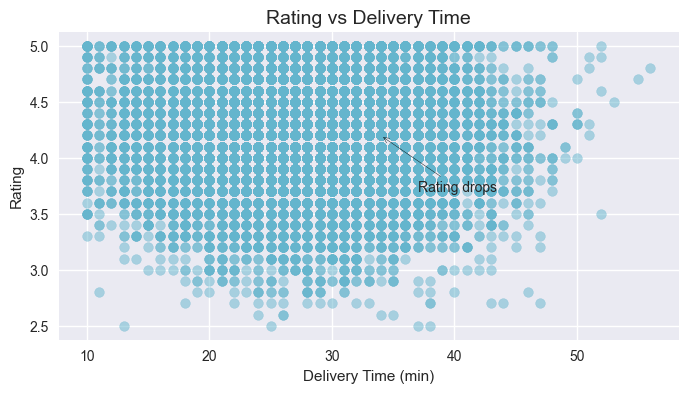

In [19]:
plt.figure(figsize=(8,4))
plt.scatter(df['delivery_time_min'], df['rating'], color=palette[4], alpha=0.5)

plt.title("Rating vs Delivery Time", fontsize=14)
plt.xlabel("Delivery Time (min)")
plt.ylabel("Rating")

plt.annotate("Rating drops",
             xy=(df['delivery_time_min'].quantile(0.8), df['rating'].mean()),
             xytext=(df['delivery_time_min'].quantile(0.9), df['rating'].mean()-0.5),
             arrowprops=dict(arrowstyle='->'))

plt.show()


## Saving the Processed Dataset


In [20]:
# df.to_csv("processed_blinkit.csv", index=False)
# df.shape

(13000, 34)

## Saving and Download Processed Dataset
This cell lets the user download the CSV directly.


In [22]:
# Merge processed dataset + column explanations into ONE CSV
# File name: processed_col_explain_blinkit.csv

column_explanation = {
    "days_to_expiry": "Difference between expiry_date and current date in days",
    "perishable": "1 if shelf_life_days < 10, else 0",
    "is_stockout": "1 if stock <= reorder_level, else 0",
    "revenue": "sold_quantity * final_price",
    "profit_value": "(profit_margin_pct/100) * revenue",
    "category_code": "Numerical encoding of product category",
    "city_code": "Numerical encoding of city",
    "discount_bucket": "Discount percentage bucketed into groups of 5"
}

explain_df = pd.DataFrame.from_dict(column_explanation, orient='index', columns=['Description'])

separator = pd.DataFrame([["--- COLUMN EXPLANATIONS BELOW ---"]], columns=["Description"])

with open("processed_col_explain_blinkit.csv", "w", encoding='utf-8') as f:
    df.to_csv(f, index=False)
    f.write("\n\n")
    separator.to_csv(f, index=False)
    f.write("\n")
    explain_df.to_csv(f)
